In [1]:
from fastai.vision.all import *

In [2]:
codes = ['Background', 'Plate']

In [3]:
codes

['Background', 'Plate']

In [4]:
path = Path("./")

In [5]:
fnames = get_image_files(path/"JPEGImages")

In [6]:
fnames

(#402) [Path('JPEGImages/000001.jpg'),Path('JPEGImages/000002.jpg'),Path('JPEGImages/000003.jpg'),Path('JPEGImages/000004.jpg'),Path('JPEGImages/000005.jpg'),Path('JPEGImages/000006.jpg'),Path('JPEGImages/000007.jpg'),Path('JPEGImages/000008.jpg'),Path('JPEGImages/000009.jpg'),Path('JPEGImages/000010.jpg')...]

In [7]:
(path/"SegmentationClassPNG").ls()[0]

Path('SegmentationClassPNG/.ipynb_checkpoints')

In [8]:
msk = PILMask.create(f'SegmentationClassPNG/000121.png')

In [9]:
np.unique(msk)

array([ 0, 38], dtype=uint8)

In [10]:
p2c = {0:0,1:38}

In [75]:
 for i, val in enumerate(p2c):
        #print(i,val) 0,0 nad 1,1
        msk = np.array(msk)
        msk[msk==p2c[i]] = val
        print(p2c[i])
msk

0
38


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [68]:
np.max(msk)

38

In [11]:
def get_msk(fn, p2c):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = path/'SegmentationClassPNG'/f'{fn.stem}.png'
    msk = np.array(PILMask.create(fn))
    mx = np.max(msk)
    for i, val in enumerate(p2c):
        msk[msk==p2c[i]] = val
    return PILMask.create(msk)

In [12]:
get_y = lambda o: get_msk(o, p2c)

In [13]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [14]:
dls = binary.dataloaders(path/"JPEGImages", path=path, bs=8)

/home/uygar/.local/lib/python3.8/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


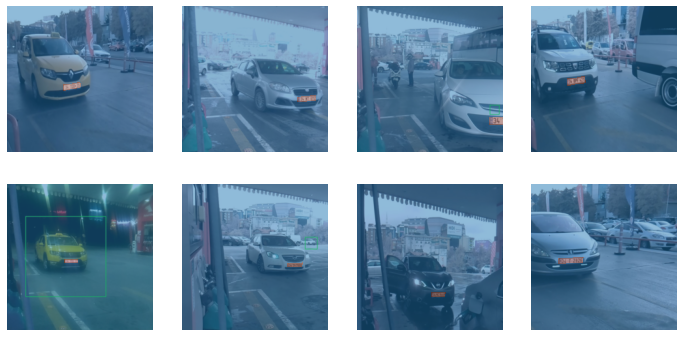

In [15]:
dls.show_batch()

In [16]:
learn = unet_learner(dls, resnet34)

In [17]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,0.040592,0.005141,00:11


epoch,train_loss,valid_loss,time
0,0.003002,0.001991,00:12
1,0.002539,0.001800,00:12
2,0.002056,0.001695,00:12
3,0.001756,0.001389,00:12
4,0.001533,0.001449,00:12
5,0.001408,0.001344,00:12


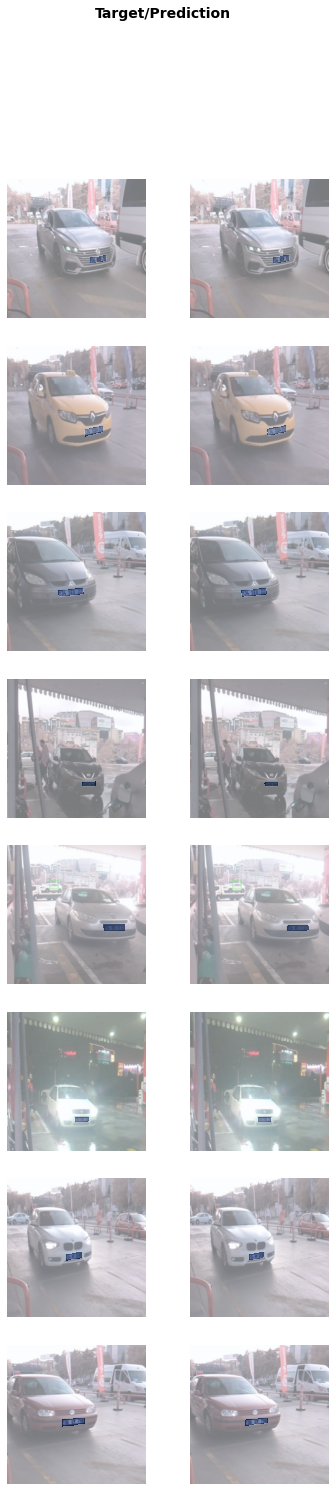

In [18]:
 learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [28]:
model = learn.model.eval()

In [20]:
model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [22]:
prd = learn.predict("JPEGImages/000005.jpg")

In [24]:
prd[0].shape

torch.Size([224, 224])

In [21]:
import cv2

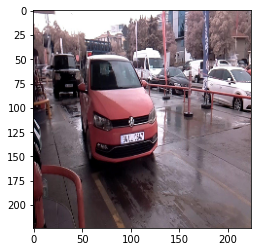

In [83]:
image = cv2.imread("JPEGImages/000383.jpg")[...,::-1]
image = cv2.resize(image,(224,224)) / 255.
plt.imshow(image)
#1,224,224,3

In [84]:
tensor = torch.tensor(image[None]).permute(0,3,1,2).cuda().float()
f1 = time.time()
with torch.no_grad():
    pred = model(tensor)
fps = 1 / (time.time() - f1)

print(fps)

99.1373735463742


In [85]:
pred.shape

torch.Size([1, 2, 224, 224])

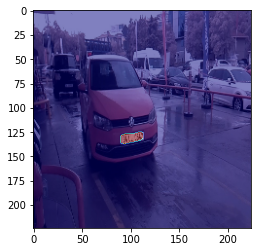

In [90]:
plt.imshow(image)
plt.imshow(pred[0].cpu().numpy().transpose(1,2,0)[:,:,1]>0.6,cmap="jet",alpha =0.5)


In [91]:
pred[0].cpu().numpy().transpose(1,2,0)[:,:,1]>0.6

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [93]:
torch.jit.save(torch.jit.trace(model,torch.randn([1,3,224,224]).cuda().float()),"segmentation_fastai_jit.pt")

In [94]:
model_jit = torch.jit.load("segmentation_fastai_jit.pt").cuda().eval()

In [101]:
tensor = torch.tensor(image[None]).permute(0,3,1,2).cuda().float()
f1 = time.time()
with torch.no_grad():
    pred = model_jit(tensor)
fps = 1 / (time.time() - f1)

print(fps)

149.486919951529


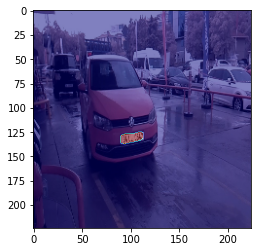

In [102]:
plt.imshow(image)
plt.imshow(pred[0].cpu().numpy().transpose(1,2,0)[:,:,1]>0.6,cmap="jet",alpha =0.5)